In [2]:
import numpy as np

# Define the grid size and actions
grid_size = 5
n_actions = 4  # Actions: up, down, left, right

# Initialize the Q-table with zeros
Q_table = np.zeros((grid_size * grid_size, n_actions))

In [20]:
alpha = 0.4  # Learning rate
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.4  # Exploration rate for epsilon-greedy policy

In [21]:
# Reward matrix for the grid environment
rewards = np.full((grid_size * grid_size,), -1)  # -1 for every state
rewards[24] = 10  # Goal state
rewards[12] = -10  # Pitfall state

In [22]:
def get_next_state(state, action, grid_size):
    row, col = divmod(state, grid_size)
    if action == 0 and row > 0:         # up
        row -= 1
    elif action == 1 and row < grid_size - 1:  # down
        row += 1
    elif action == 2 and col > 0:       # left
        col -= 1
    elif action == 3 and col < grid_size - 1:  # right
        col += 1
    return row * grid_size + col

In [23]:
rewards

array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  10])

In [24]:
def epsilon_greedy_action(Q_table, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions), False  # Explore: random action
    else:
        return np.argmax(Q_table[state]), True  # Exploit: action with highest Q-value

In [25]:
# Simulation loop
states = []
actions = []
episode_rewards = []
rewards_q_learning = []  # Placeholder for Q-learning rewards
steps_q_learning_per_episode = []  # Placeholder for steps in q-learning
exploration_count_q_learning = 0
exploitation_count_q_learning = 0

for episode in range(1000):
    state = np.random.randint(0, grid_size * grid_size)  # Start in a random state
    done = False
    total_reward = 0
    steps_q_learning = 0  # Reset steps for each episode
    while not done:
        action, exploit = epsilon_greedy_action(Q_table, state, epsilon)
        if exploit:
            exploitation_count_q_learning += 1
        else:
            exploration_count_q_learning += 1
        next_state = get_next_state(state, action, grid_size) # Simulated next state
        reward = rewards[next_state]
        total_reward += reward
        steps_q_learning += 1
        # Update Q-value using Bellman equation
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

        state = next_state
        if next_state == 24 or next_state == 12:
            done = True

    rewards_q_learning.append(total_reward)
    steps_q_learning_per_episode.append(steps_q_learning)
rewards_q_learning = np.array(rewards_q_learning)

In [26]:
# Calculate success rate
success_count_q_learning = sum(1 for reward in rewards_q_learning if reward >= 10)
success_rate_q_learning = success_count_q_learning / len(rewards_q_learning)

# Exploration vs. exploitation ratio
#print(actions)
exploration_exploitation_ratio_q_learning = exploration_count_q_learning / (exploration_count_q_learning + exploitation_count_q_learning)

print(f"Success Rate Q-learning: {success_rate_q_learning * 100}%")
print(f"Exploration vs. Exploitation Ratio Q-learning: {exploration_exploitation_ratio_q_learning}")

Success Rate Q-learning: 9.8%
Exploration vs. Exploitation Ratio Q-learning: 0.39368355222013757


In [89]:
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

/home/davy/Documents/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [90]:
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])

In [91]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

In [92]:
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [93]:
cumulative_rewards = compute_cumulative_rewards(rewards)

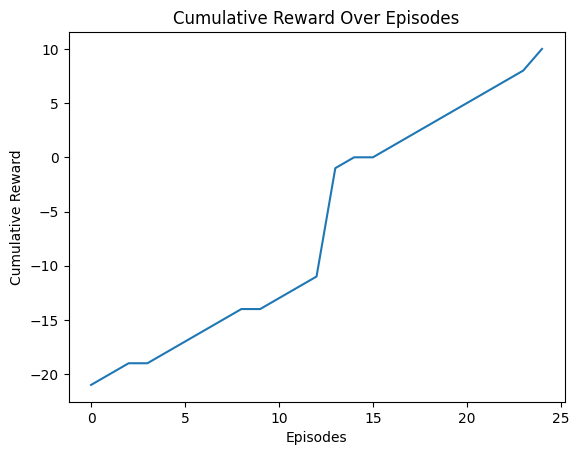

In [94]:
# Plot the cumulative rewards over episodes
plt.plot(cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Over Episodes')
plt.show()

In [ ]:
# Policy Gradients Implementation for Grid Environment
rewards_policy_gradients = []
steps_policy_gradients_per_episode = []
n_episodes = 1000
exploration_count_policy_gradients = 0
exploitation_count_policy_gradients = 0
for episode in range(n_episodes):
    states = []
    actions = []
    rewards_ep = []
    steps_policy_gradients = 0
    state = np.random.randint(0, grid_size * grid_size)
    done = False
    while not done:
        action = get_action(state)
        next_state = get_next_state(state, action, grid_size) # Simulated next state  # Simulated next state
        reward = rewards[next_state]
        states.append(state)
        actions.append(action)
        rewards_ep.append(reward)
        state = next_state
        steps_policy_gradients += 1
        if next_state == 24 or next_state == 12:
            done = True
    update_policy(states, actions, rewards_ep)
    rewards_policy_gradients.append(np.sum(rewards_ep))
    steps_policy_gradients_per_episode.append(steps_policy_gradients)
rewards_policy_gradients = np.array(rewards_policy_gradients)
# Policy gradients is a reinforcement learning method that directly optimizes the policy by adjusting its parameters to maximize expected reward, using gradients computed from sampled episodes.



In [96]:
actions

[3, 3]

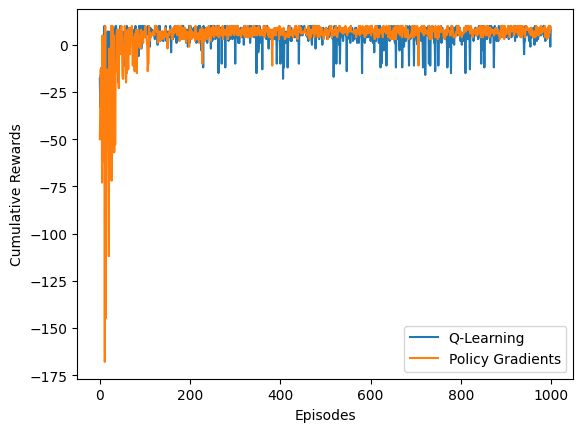

In [98]:
import matplotlib.pyplot as plt

# Example code to visualize rewards over episodes
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_policy_gradients, label='Policy Gradients')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()

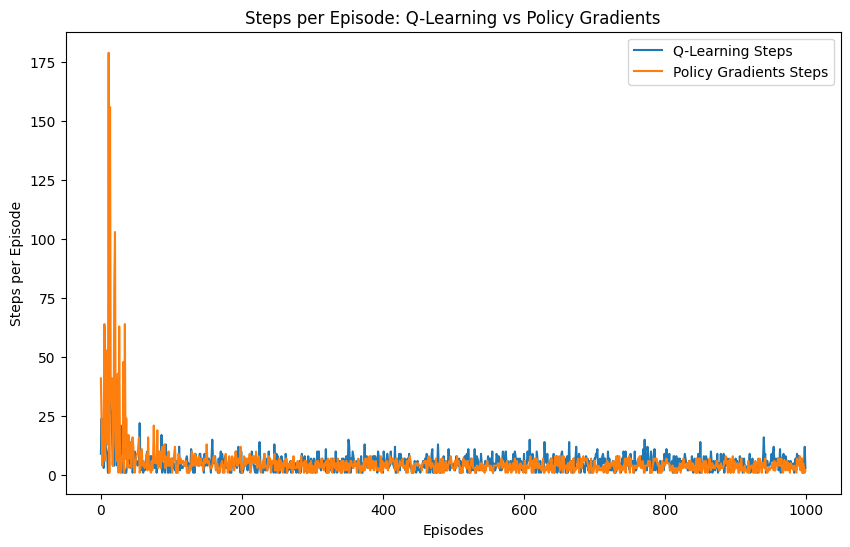

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(steps_q_learning_per_episode, label='Q-Learning Steps')
plt.plot(steps_policy_gradients_per_episode, label='Policy Gradients Steps')
plt.xlabel('Episodes')
plt.ylabel('Steps per Episode')
plt.title('Steps per Episode: Q-Learning vs Policy Gradients')
plt.legend()
plt.show()

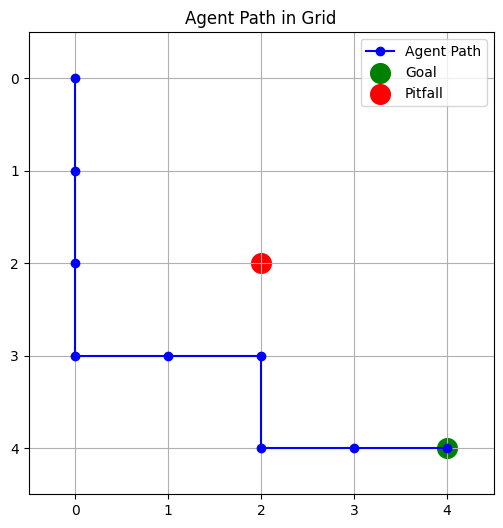

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_agent_path(Q_table, grid_size, start_state=0, goal_states=[24], pitfall_states=[12]):
    state = start_state
    path = [state]
    max_steps = 50  # Prevent infinite loops
    for _ in range(max_steps):
        action = np.argmax(Q_table[state])
        next_state = get_next_state(state, action, grid_size)
        path.append(next_state)
        if next_state in goal_states or next_state in pitfall_states:
            break
        state = next_state

    # Convert states to (row, col) for plotting
    coords = [divmod(s, grid_size) for s in path]
    rows, cols = zip(*coords)

    plt.figure(figsize=(6,6))
    plt.grid(True)
    plt.xlim(-0.5, grid_size-0.5)
    plt.ylim(-0.5, grid_size-0.5)
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.gca().invert_yaxis()
    plt.plot(cols, rows, marker='o', color='b', label='Agent Path')
    plt.scatter([goal_states[0]%grid_size], [goal_states[0]//grid_size], color='g', s=200, label='Goal')
    plt.scatter([pitfall_states[0]%grid_size], [pitfall_states[0]//grid_size], color='r', s=200, label='Pitfall')
    plt.title('Agent Path in Grid')
    plt.legend()
    plt.show()

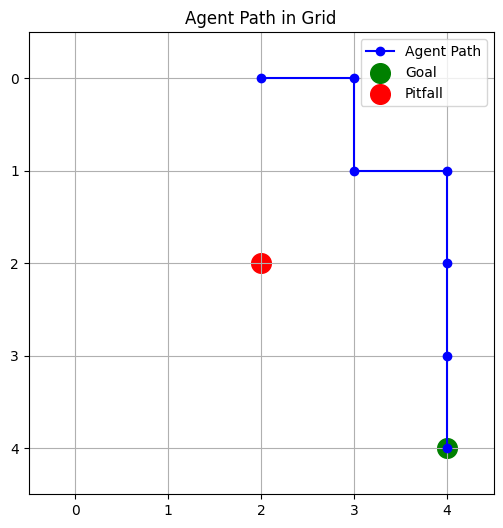

In [104]:
# Example usage: plot the path from top-left (state 0)
plot_agent_path(Q_table, grid_size, start_state=2)